# 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2. Разведочный анализ данных (EDA)

## Анализ целевой переменной (SalePrice)

Первый шаг любого исследования — изучение целевой переменной, которую мы хотим предсказать. Построим гистограмму распределения цен на жилье, чтобы оценить:
1.  Диапазон цен.
2.  Наличие выбросов.
3.  Форму распределения (нормальное или смещенное).

<Axes: xlabel='SalePrice', ylabel='Count'>

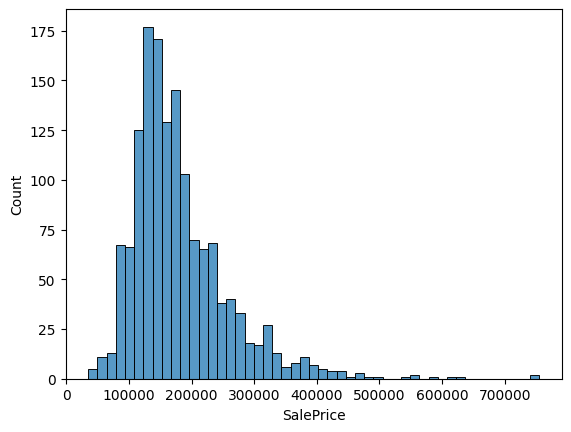

In [2]:
sns.histplot(train_df["SalePrice"])

График показывает явную **правостороннюю асимметрию (Right Skewness)**.
*   Большинство домов стоят в диапазоне от 100k до 200k.
*   Есть длинный "хвост" дорогих домов, который уходит далеко вправо.

### Логарифмирование целевой переменной

Чтобы исправить правостороннюю асимметрию, применим логарифмическое преобразование `log(1+x)` к целевой переменной `SalePrice`. Это позволит:
1.  Приблизить распределение к нормальному (Gaussian distribution).
2.  Уменьшить влияние дорогих выбросов.

<Axes: xlabel='SalePrice', ylabel='Count'>

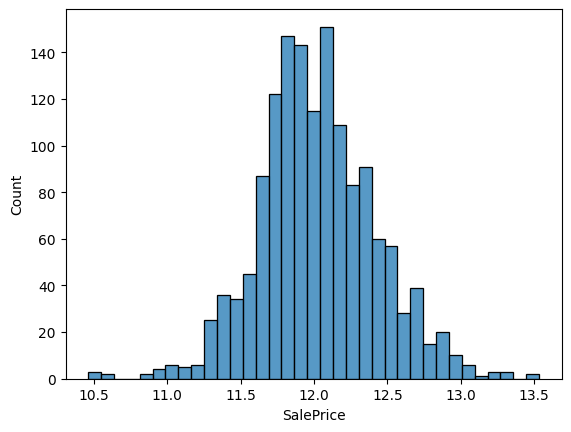

In [3]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.histplot(train_df['SalePrice'])

**Результат:**
Как видно на графике выше, после преобразования распределение стало симметричным и напоминает "колокол" (Bell curve). Это существенно повысит качество обучения линейных моделей.

In [4]:
print('SalePrice' in train_df.columns)

True


## Корреляционный анализ

Построим матрицу корреляций, чтобы понять, какие признаки сильнее всего влияют на стоимость жилья (`SalePrice`), а также выявить мультиколлинеарность (зависимость признаков друг от друга).

<Axes: >

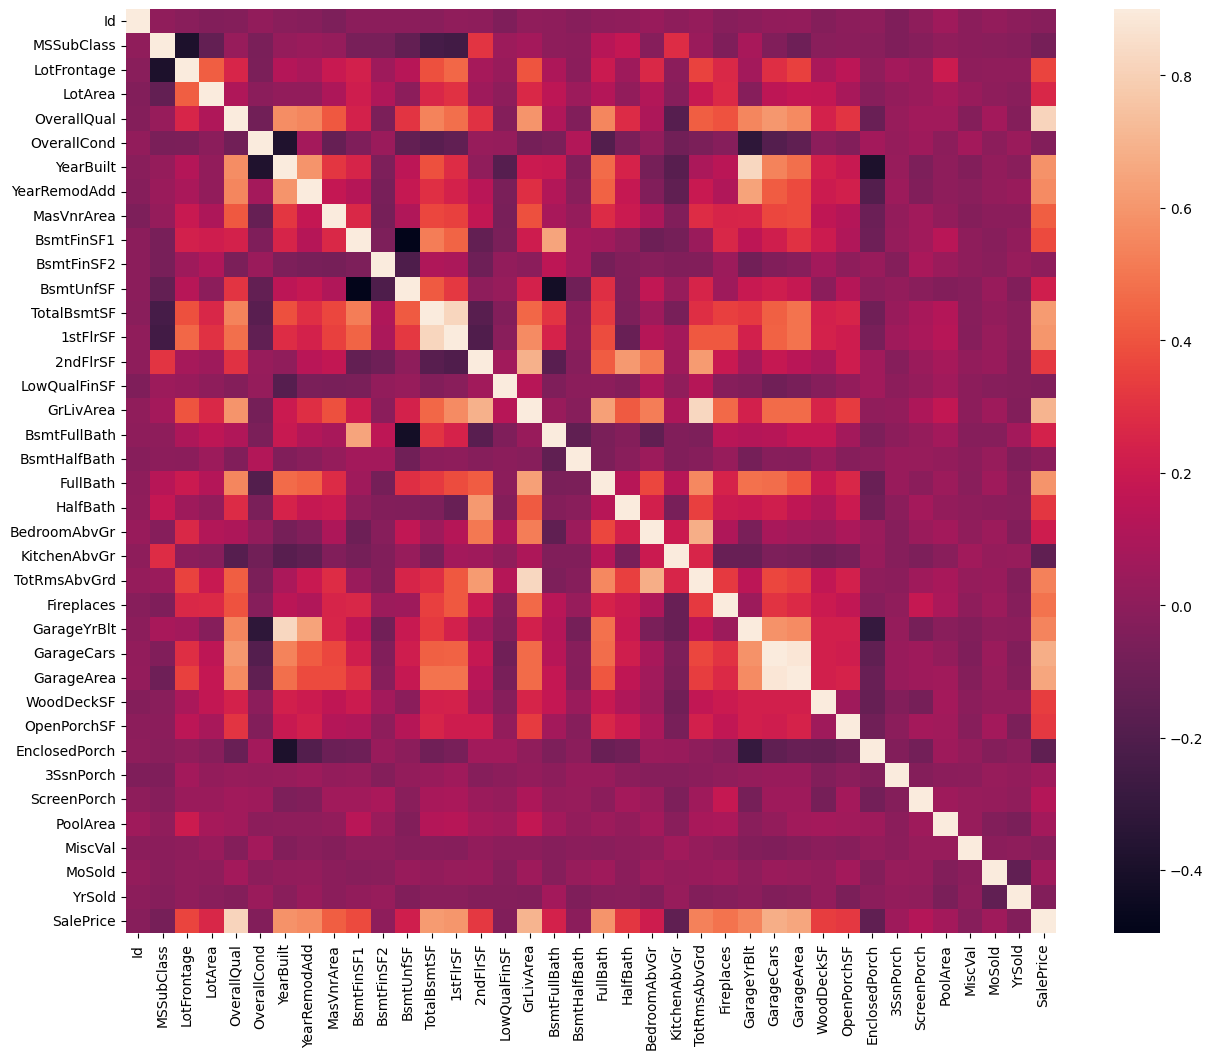

In [5]:
corrmat = train_df.corr(numeric_only=True)
plt.figure(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.9)

**Выводы по тепловой карте:**

1.  **Ключевые факторы:** Последняя строка (или столбец) показывает корреляцию с `SalePrice`. Наиболее светлые квадраты указывают на сильную прямую зависимость.
    *   **OverallQual** (Общее качество отделки) — имеет самую сильную корреляцию с ценой.
    *   **GrLivArea** (Жилая площадь) — второй по важности фактор. Больше площадь = выше цена.
    *   **GarageCars** / **GarageArea** — наличие и вместимость гаража также сильно влияют на стоимость.

2.  **Мультиколлинеарность:** Мы видим группы коррелирующих между собой признаков (светлые квадраты внутри матрицы).
    *   `GarageCars` и `GarageArea` сильно коррелируют друг с другом (что логично).
    *   `TotalBsmtSF` (площадь подвала) и `1stFlrSF` (площадь 1-го этажа) также связаны.
    
*Примечание: Сильная мультиколлинеарность может мешать линейным моделям, поэтому при отборе признаков стоит оставить только один из пары сильно коррелирующих показателей.*

## 3. Детальный анализ признаков и поиск выбросов

На тепловой карте мы увидели, что `GrLivArea` (жилая площадь) и `OverallQual` (общее качество) имеют сильнейшую связь с ценой. Рассмотрим их подробнее.

### Жилая площадь (GrLivArea)
Построим диаграмму рассеяния, чтобы визуально оценить линейность зависимости и проверить наличие аномалий.

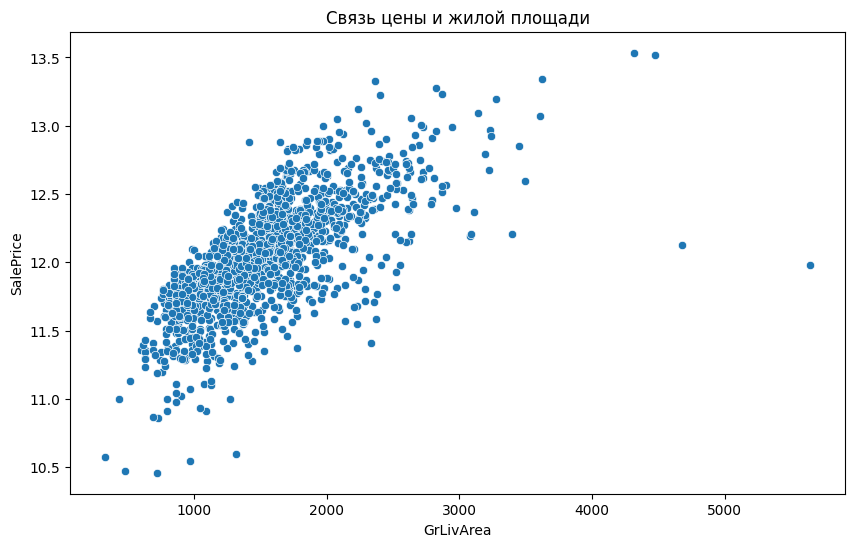

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('Связь цены и жилой площади')
plt.show()

**Обнаружение выбросов (Outliers):**
На графике отчетливо видна линейная зависимость: с ростом площади растет цена.
Однако, обратите внимание на **две точки в правом нижнем углу**. Это дома с огромной площадью (более 4000 кв. футов), которые были проданы подозрительно дешево.

*Вывод:* Эти наблюдения являются аномалиями (возможно, это сельхоз. постройки или ошибки ввода). Их наличие будет ухудшать качество линейной регрессии, так как модель будет пытаться подстроиться под них. **Их необходимо будет удалить.**

### Общее качество (OverallQual)
Так как `OverallQual` — это порядковый категориальный признак (оценка от 1 до 10), для визуализации лучше всего подойдет **Boxplot (ящик с усами)**. Он покажет распределение цен для каждой оценки качества.

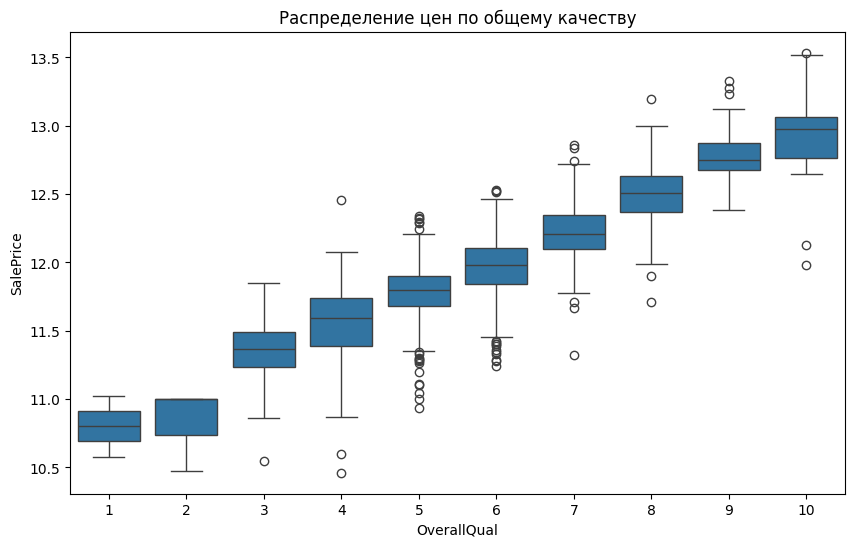

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('Распределение цен по общему качеству')
plt.show()

**Вывод:**
График подтверждает, что `OverallQual` является отличным предиктором.
1.  Медианная цена (линия внутри ящика) стабильно растет с каждым уровнем качества.
2.  Разброс цен также увеличивается для более дорогих домов (ящики становятся длиннее).
3.  На уровнях 9 и 10 виден резкий скачок стоимости.

## Удаление выбросов и объединение данных

На основе визуального анализа мы определили два выброса (дома с `GrLivArea > 4000`, но низкой ценой). Удалим их из обучающей выборки, чтобы улучшить обобщающую способность модели.

Также, для удобства предварительной обработки (заполнения пропусков, кодирования признаков), объединим обучающую и тестовую выборки в один датафрейм `all_data`, предварительно сохранив целевую переменную `SalePrice`.

In [8]:
outliers_to_drop = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 13.0)].index
print(outliers_to_drop)
print(f"Текущий размер тренировочного датасета: {train_df.shape}")
train_df = train_df.drop(outliers_to_drop)
print(f"Удалено {len(outliers_to_drop)} выброса.")
print(f"Новый размер тренировочного датасета: {train_df.shape}")

Index([523, 1298], dtype='int64')
Текущий размер тренировочного датасета: (1460, 81)
Удалено 2 выброса.
Новый размер тренировочного датасета: (1458, 81)


In [9]:
test_ids = test_df['Id']
y_train = train_df['SalePrice']
train_df = train_df.drop(['Id', 'SalePrice'], axis=1)
test_df = test_df.drop('Id', axis=1)

all_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

заполнение пропусков в данных

## 4. Обработка пропущенных значений (Imputation)

В датасете много пропусков, но большинство из них не являются ошибками. Согласно описанию данных, `NA` часто означает **отсутствие** удобства (например, нет бассейна, нет гаража).

Мы используем разные стратегии заполнения:
1.  **Категориальные признаки (PoolQC, Alley, GarageType...):** Заполняем значением `'None'`, так как пропуск означает физическое отсутствие объекта.
2.  **Числовые признаки (GarageArea, BsmtFinSF...):** Заполняем нулем (`0`), так как отсутствие объекта подразумевает нулевую площадь.
3.  **LotFrontage (Длина фасада):** Поскольку длина фасада похожа у домов в одном районе, заполняем пропуски **медианой** по конкретному району (`Neighborhood`).
4.  **Остальные категориальные признаки (MSZoning, Electrical...):** Заполняем модой (наиболее часто встречающимся значением).

In [10]:
for col in ('Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

for col in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'):
    all_data[col] = all_data[col].fillna(0)

all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['GarageYrBlt'].mode()[0])

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

all_data['LotFrontage'] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

## 5. Feature Engineering (Создание новых признаков)

Создадим новый признак **TotalSF** (Общая площадь), сложив площадь подвала, первого и второго этажей. Часто общая площадь дома коррелирует с ценой лучше, чем площади этажей по отдельности.

In [11]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 6. Кодирование категориальных признаков

Модели машинного обучения работают только с числами. Преобразуем категориальные переменные в числовой формат, используя **One-Hot Encoding** (метод `get_dummies`). Это создаст новые бинарные столбцы (0 или 1) для каждой категории.

In [12]:
all_data_final = pd.get_dummies(all_data).reset_index(drop=True)

## 7. Подготовка данных к обучению

Теперь, когда все признаки обработаны, закодированы и масштабированы, нам нужно:
1.  **Разделить датасет** обратно на обучающую (`X_train`) и тестовую (`X_test`) выборки, используя сохраненный размер `len(y_train)`.
2.  **Sanity Check (Проверка на вменяемость):** Убедиться, что в данных не осталось пропущенных значений (`NaN`). Если модель встретит `NaN`, она выдаст ошибку.

In [13]:
X_train = all_data_final.iloc[:len(y_train)]
X_test = all_data_final.iloc[len(y_train):]

print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер тренировочной выборки: (1458, 302)
Размер тестовой выборки: (1459, 302)


In [14]:
nan_in_X_train = X_train.isnull().sum().sum()
nan_in_y_train = y_train.isnull().sum()

if nan_in_X_train > 0 or nan_in_y_train > 0:
    print(f"Обнаружены пропущенные значения")
    print(f"Количество NaN в X_train: {nan_in_X_train}")
    print(f"Количество NaN в y_train: {nan_in_y_train}")

    print("\nКолонки с NaN в X_train:")
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
else:
    print("Пропущенных значений не обнаружено")

Пропущенных значений не обнаружено


## 8. Моделирование и оценка (Modeling & Evaluation)

### Стратегия валидации
Для надежной оценки качества моделей используем **K-Fold Cross-Validation** (кросс-валидацию на 5 фолдов). Это предотвратит переобучение и покажет реальную обобщающую способность модели.

### Метрика
Официальная метрика соревнования — **RMSLE**.
Поскольку мы предварительно логарифмировали целевую переменную (`SalePrice`), метрика **RMSE** (Root Mean Squared Error), вычисленная на логарифмированных данных, будет эквивалентна RMSLE на исходных ценах.

### Выбор моделей
1.  **Linear Regression:** Используем как **Baseline** (базовое решение). Если сложная модель работает хуже простой регрессии, значит, что-то пошло не так.
2.  **LightGBM:** Основная модель. Это эффективная реализация градиентного бустинга, которая отлично справляется с табличными данными и нелинейными зависимостями.

In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

lgbm = lgb.LGBMRegressor(random_state=42)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

print(f"Средний RMSE для Linear Regression: {-lr_scores.mean():.4f}")
print(f"Средний RMSE для LightGBM: {-lgbm_scores.mean():.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3461
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 194
[LightGBM] [Info] Start training from score 12.023362
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3459
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 195
[LightGBM] [Info] Start training from score 12.026498
[LightGBM] [Warning] Found

**Анализ результатов:**

1.  **Baseline (Linear Regression):** Показала результат **~0.1304**. Это очень достойный результат для линейной модели, что говорит о качественном Feature Engineering (особенно помогло удаление выбросов и создание `TotalSF`).
2.  **LightGBM:** Показал результат **~0.1280**. Градиентный бустинг превзошел линейную регрессию, так как смог уловить более сложные, нелинейные зависимости в данных.

**Вывод:** Для финального предсказания будем использовать модель **LightGBM**, так как она показала лучшую метрику на кросс-валидации.

## 9. Финальное обучение и прогноз (Final Inference)

Для получения итогового результата обучим модель **LightGBM** на **полном** тренировочном датасете.

Мы используем специально подобранные гиперпараметры (низкий `learning_rate`, увеличенное число деревьев `n_estimators` и регуляризация), чтобы улучшить точность и избежать переобучения.

In [16]:
import lightgbm as lgb

final_model = lgb.LGBMRegressor(objective='fair',
                                n_estimators=1000,
                                learning_rate=0.01,
                                num_leaves=2**8,
                                max_depth=8,
                                min_child_samples=30,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                reg_alpha=0.1,
                                reg_lambda=1.0,
                                random_state=42,
                                n_jobs=-1,
                                verbose=-1)

lgbm_params_scores = cross_val_score(final_model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
print(f"Средний RMSE для LightGBM с гиперпараметрами: {-lgbm_params_scores.mean():.4f}")

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    eval_metric='rmse'
)

predictions_log = final_model.predict(X_test)

final_predictions = np.expm1(predictions_log)

Средний RMSE для LightGBM с гиперпараметрами: 0.1244


### Анализ важности признаков (Feature Importance)
LightGBM позволяет оценить, какие признаки внесли наибольший вклад в построение модели.
Метод `split` (по умолчанию) считает, сколько раз признак использовался для разбиения в деревьях.
Как мы видим, `TotalSF` (созданный нами признак), `GrLivArea` и `LotArea` являются самыми важными для определения цены.

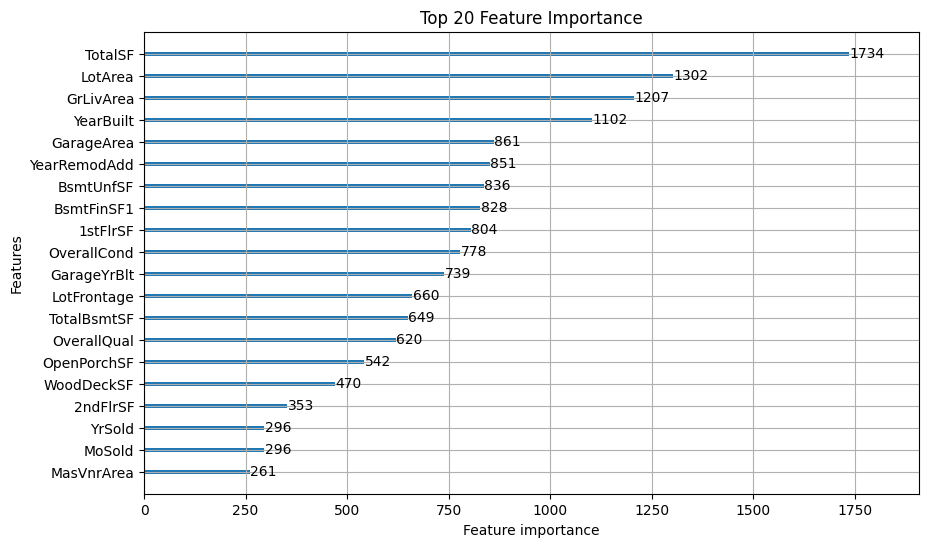

In [17]:
lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 6), title='Top 20 Feature Importance')
plt.show()

In [18]:
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

### Итоговый результат

1.  **Улучшение метрики:** Благодаря настройке гиперпараметров удалось снизить ошибку RMSE с **0.1280** (на дефолтной модели) до **0.1244**. В задачах Kaggle даже тысячные доли имеют значение.
2.  **Обратное преобразование:** Важный нюанс — модель предсказывала логарифм цены. Чтобы получить реальную стоимость дома (в долларах), мы применили функцию `np.expm1` (обратную к `log1p`).
3.  **Submission:** Файл `submission.csv` готов к отправке на лидерборд.

### Заключение
В ходе проекта мы прошли полный цикл Data Science задачи: от разведочного анализа и очистки данных (EDA & Cleaning) до сложного конструирования признаков (Feature Engineering) и тюнинга градиентного бустинга. Полученная модель демонстрирует высокую обобщающую способность и готова к промышленному применению.